<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/sound/sound_data_%EC%8B%9C%EA%B0%81%ED%99%94_%EB%B6%84%EB%A5%98_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: 캐글의 [Kaggle | GTZAN dataset](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)을 사용합니다.

참고한 notebook은 https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend/data 입니다.


### Data 설명

- genres_original : 
  - 각각 100개의 파일을 포함한 10개의 장르 데이터셋.
  - 각 음원은 30초 길이
- images_original
  - 각각의 음원에 대한 시각적 표현
  - audio file --> mel spectorgram
- 2개의 csv 파일
  - audio file의 feature들 포함
    - 하나는 3초 이하로 끊겨있음 (10배의 데이터 연료를 얻을 수 있다고 말함)

사람들은 음성을 인식할 때 주파수를 linear scale로 인식하지 못하기 때문에 mel scale로 바꿔서 표현한다.

[mel spectogram 설명 블로그 참조](https://judy-son.tistory.com/6)



### Goal

- audio file을 이해한다.
- 음원 데이터에 대해 어떤 부분을 시각화 할 수 있는지 확인
- EDA
- 3초 간격의 csv 파일을 통한 장르 분류
- 추천시스템 : 가장 유사한 음원 추천

### library import

기본 라이브러리 (일반적으로 사용하는 라이브러리 import)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

In [2]:
# librosa는 audio계의 mother이라 한다.
import librosa
import librosa.display
import IPython.display as ipd

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

구글 드라이브를 통해 데이터를 불러오겠습니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/kaggle/music_data/input/

/content/drive/MyDrive/kaggle/music_data/input


In [5]:
ls

features_30_sec.csv  features_3_sec.csv  genres_original/  images_original/


## Explore audio data

In [9]:
import os
music_path = 'genres_original'
print(os.listdir(music_path))

['hiphop', 'pop', 'reggae', 'country', 'disco', 'classical', 'blues', 'metal', 'rock', 'jazz']


30초 길이의 음원들이 수록된 하위 폴더 목록을 확인할 수 있다. hiphop, pop, reggae 등 총 10가지 장르로 구성된다.

**audio data가 어떻게 생겼는지 확인**해보자. 

참고한 notebook과 같이 ```reggae.00036.wav file```을 갖고 진행해보겠다.

- Sound : 압력 강도인 (y)에 따라 변화하는 일련의 진동이다.
- sample rate(sr): Hz 또는 kHz로 측정된 1초 단위의 sample들이다.

In [17]:
# 하나의 음원 출력
y, sr = librosa.load('genres_original/reggae/reggae.00036.wav')

y_sample = np.shape(y)
print('y: ',y)
print('y.sample: ',y_sample)
print('sample rate(kHz) :',sr)
print('Check length of audio: ',y_sample[0]/sr)

y:  [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
y.sample:  (661794,)
sample rate(kHz) : 22050
Check length of audio:  30.013333333333332


**실질적인 audio 시작전 silence한 부분을 trimming해준다.**

In [19]:
audio_file, _ = librosa.effects.trim(y)

# the result is numpy ndarray
print('audio_file: ', audio_file, '\n')
print('audio_file.shape: ',np.shape(audio_file))

audio_file:  [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

audio_file.shape:  (661794,)


**2D representation : Sound Waves**

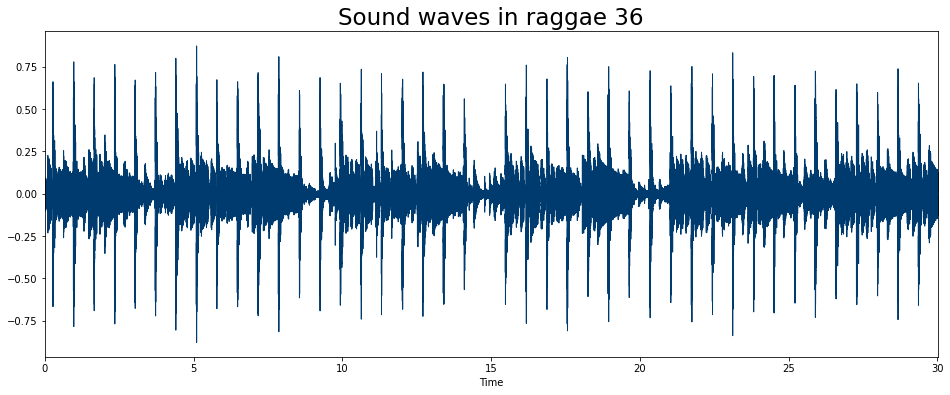

In [20]:
plt.figure(figsize=(16,6))
librosa.display.waveplot(y=audio_file, sr=sr, color='#003b6f');
plt.title("Sound waves in raggae 36", fontsize=23);

**푸리에 변환 (Fourier Transform)**

시간 t축에 존재하는 신호나 정보를 주파수 f(혹은w)로 옮겨온다는 것 

전 시간 영역을 적분하여 주파수 영역에 대한 수식으로 전환한다.

[푸리에 변환에 대한 설명 글](https://renelemon.tistory.com/75)

[3Blue1Brown | (푸리에 변환 설명 youtube)](https://youtu.be/spUNpyF58BY)

- y-axis(frequencies) --> log scale
- "color" axis (amplitude:진폭) --> 데시벨(Decibels); approx (amplitude의 log)

**FFT(Fast Fourier Transform, 고속 푸리에 변환)**

FFT이론은 무한히 연속되어 있는 시간도메인 신호 모두가 주파수 도메인 스펙트럼으로 변한다는 것을 가정하고 있다. 

그러나 이론과 실제의 차이가 발생하는데, 이를 극복하기 위해 주기성과 대칭성을 이용한다. 

주기성과 대칭성이라는 개념은 신호의 특정 부분에서 같은 신호가 무한히 반복된다고 보고 푸리에 연산을 수행한다. 

주파수 f(또는 w)의 변화도 Δf(주파수 분해능)의 배수에 해당하는 여러 주파수 빈으로 나뉘게 된다. (Δf= 1/포착된 신호의 길이(T))

- 포착된 신호의 길이(Capture Time: T)에 의해 FFT 주파수 분해능이 결정됨
- 샘플링 속도, 메모리 길이 --> 최대 주파수 범위 SPAN 결정

  [(FFT란 무엇인가 블로그 설명 글 참조)](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=lecroykorea&logNo=130182273773)

- 실시간으로 신호의 주파수를 분석하고자 하는 욕구가 생겼고, 이를 가능하게 하는 방법이 FFT. 

  실제로는 실시간 분석은 아니고 '시간을 조각내서 주파수 분석을 올려줌'  [(참고| FFT란)](https://scribblinganything.tistory.com/181)

**Default FFT window size**
- window size: 한 번에 받을 수 있는 데이터의 양

In [21]:
'''
STFT(Short time Fourier Transform) 
# : 시간 정보를 보존하기 위해 단순 푸리에 단위와 다르게 frame 단위로 FFT 수행
# 따라서 Frame 수와 Frame 당 sample 수를 지정해줘야 한다.
'''
n_fft = 2048                # FFT window size ; Frame 하나당 sample 수
hop_length = 512            # 전체 Frame 수

# STFT(Short time fourier transform)
D = np.abs(librosa.stft(audio_file, n_fft=n_fft, hop_length= hop_length))

print('shape of D object: ',np.shape(D))

shape of D object:  (1025, 1293)


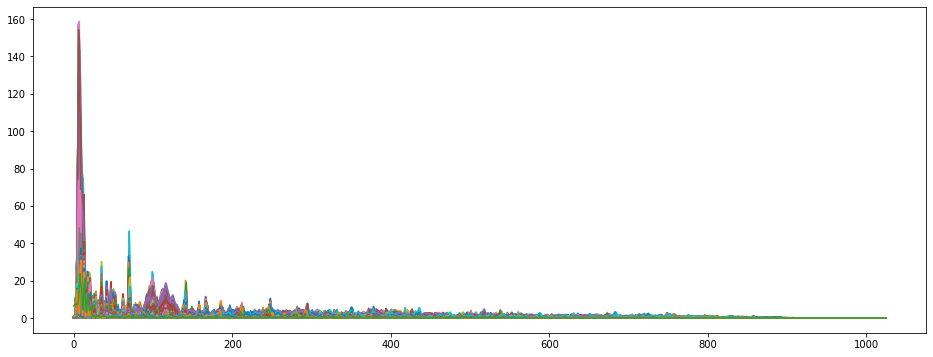

In [22]:
plt.figure(figsize=(16,6))
plt.plot(D);

**The Spectogram**

스펙토그램: 파형과 스펙트럼이 결합된 것

- x축은 시간
- y축은 주파수(frequency)
- z축은 진폭 (amplitude)

참고) 스펙트럼: x축은 주파수, y축은 진폭

[(스펙토그램 설명 | 블로그 글 참조)](https://ahnjg.tistory.com/43)

audio signal에 적용될 경우 sonographs, voiceprints, or voicegrams로 불린다고 한다. [(Spectogram| wikipedia)](https://en.wikipedia.org/wiki/Spectrogram)

주파수 axis (Frequency axis) --> log 취해줌

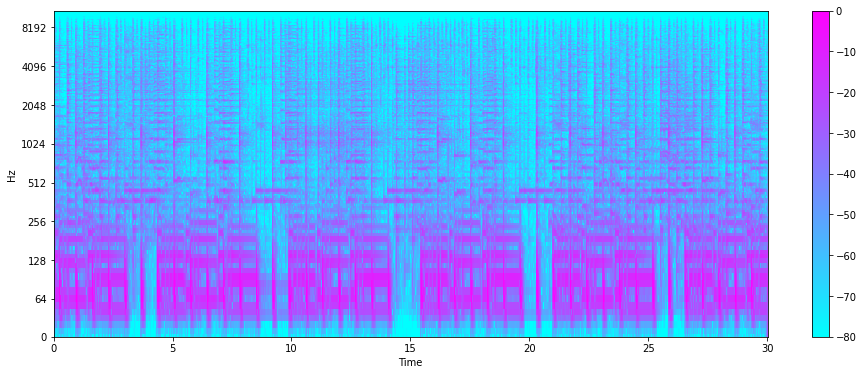

In [88]:
# 진폭(amplitude) spectogram을 Decibels-scaled spectogram으로 변환
DB = librosa.amplitude_to_db(D, ref=np.max)

# Spectogram create
plt.figure(figsize=(16,6))
librosa.display.specshow(DB, sr=sr, hop_length= hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar();

**Mel Spectrogram**

- 기본 스펙토그램이지만 y축에 Mel scale이 있는 것

**metal 36**

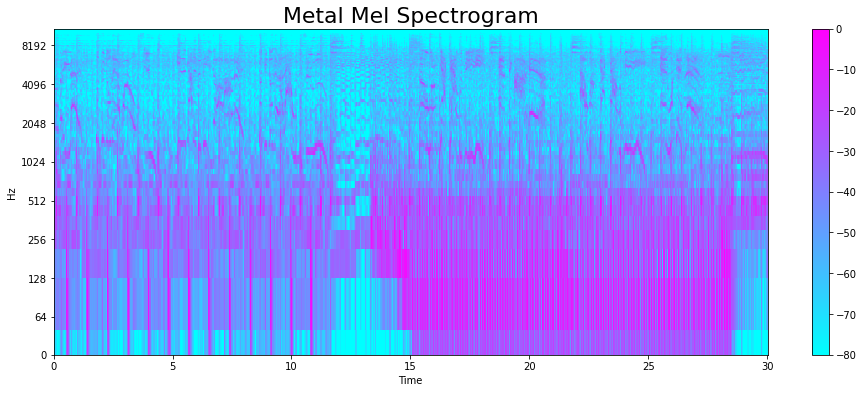

In [31]:
y, sr = librosa.load('genres_original/metal/metal.00036.wav')     # metal 장르 36번 load
y, _ = librosa.effects.trim(y)                                    # trimming

S = librosa.feature.melspectrogram(y, sr=sr)                      # melspectrogram
S_DB = librosa.amplitude_to_db(S, ref=np.max)                     # 진폭을 decibels-scaled spectogram으로 변환

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize=22);


**pop 36**

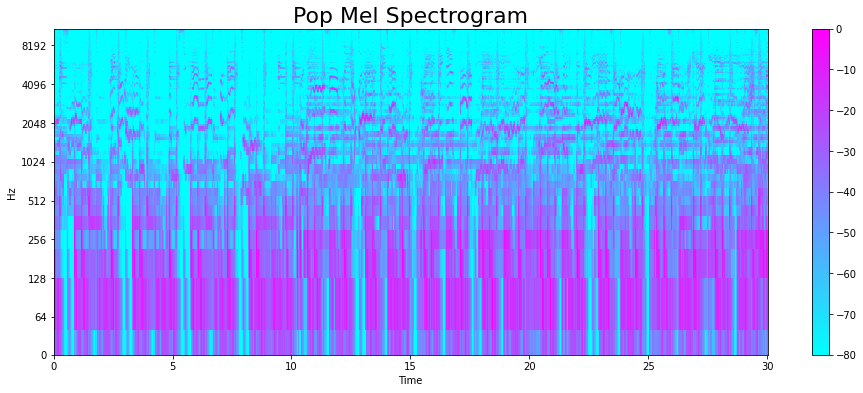

In [32]:
y, sr = librosa.load('genres_original/pop/pop.00036.wav')         # pop 장르 36번 load
y, _ = librosa.effects.trim(y)                                    # trimming

S = librosa.feature.melspectrogram(y, sr=sr)                      # melspectrogram
S_DB = librosa.amplitude_to_db(S, ref=np.max)                     # 진폭을 decibels-scaled spectogram으로 변환

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar();
plt.title("Pop Mel Spectrogram", fontsize=22);

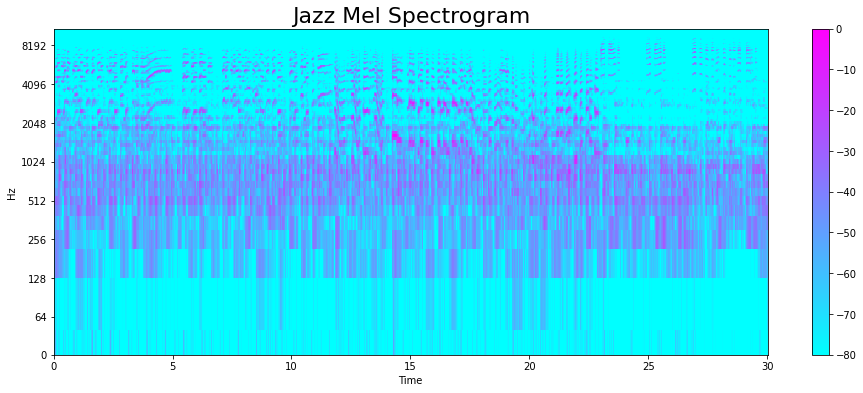

In [33]:
y, sr = librosa.load('genres_original/jazz/jazz.00036.wav')       # jazz 장르 36번 load
y, _ = librosa.effects.trim(y)                                    # trimming

S = librosa.feature.melspectrogram(y, sr=sr)                      # melspectrogram
S_DB = librosa.amplitude_to_db(S, ref=np.max)                     # 진폭을 decibels-scaled spectogram으로 변환

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar();
plt.title("Jazz Mel Spectrogram", fontsize=22);

### **Audio features**

**Zero crossing rate(ZCR, 영교차율)**

- 신호가 0을 지나는
- 신호의 부호가 바뀌는 비율

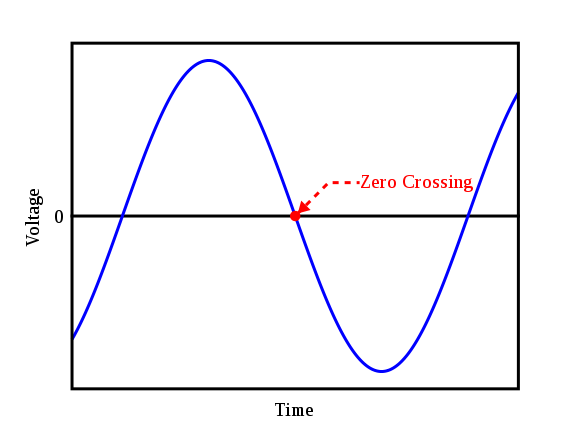 

(위키피디아 Zero Crossing 그림 참조)

In [34]:
# 하나의 음원에 대한 zero crossing 진행해보기
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

39232


**Harmonics and Percussive**

- Harmonics : 인간의 귀가 구별할 수 없는 특성(소리의 color를 대표하는)
- Percussive: 리듬과 감정을 나타내는 충격파
  - 리듬과 감정(emotion)을 대표하는 충격파(shock wave)
  - 쳐서 소리를 내는
  - shock wave(충격파): 음속보다 빠르게 전달되는 압력파동

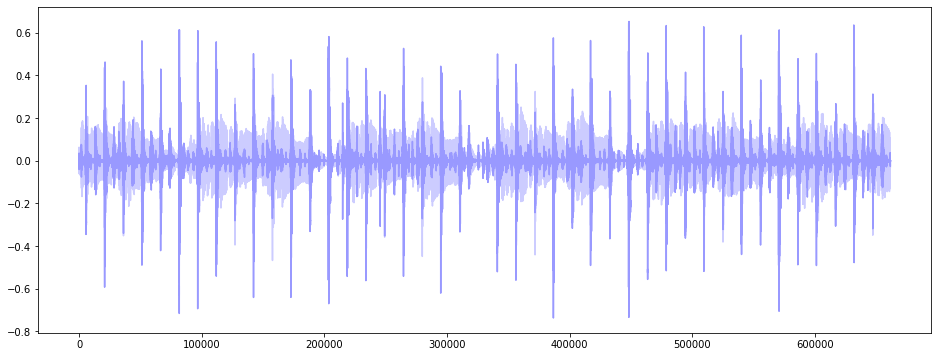

In [41]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#CCCCFF');  # 연한 색상
plt.plot(y_perc, color = '#9999FF');  # 진한 색상

**Tempo BMP (Beat for minute)**: 분당 몇 비트의 템포로 연주되는가

[(나무 위키| **BPM** 설명)](https://namu.wiki/w/BPM)
- 장르 별 BPM도 있음

In [42]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)  # 마지막 y가 jazz였음 #sr: 1초 단위의 sample
tempo

123.046875

**Spectral Centroid**

- sound가 위치한 중심을 명시함. 
- sound에서 나타나는 빈도수에(frequencies) 따른 가중평균(wieghted mean)으로 계산

In [44]:
# Spectral Centroid (중심) 계산
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# shape은 vector로 나타난다.
print('Centroids :', spectral_centroids)
print('Shape of Spectral Centroid :',spectral_centroids.shape)

# 시각화를 위한 time 변수 computing
frames = range(len(spectral_centroids))

# time 변수 frames 변환: counts to time (seconds)
t= librosa.frames_to_time(frames)

print('Frames: ',frames, '\n')
print('t(counts to time): ',t)

Centroids : [1817.93364736 1953.08392985 2038.8113414  ...  766.50416352 1019.33192639
 1081.69931747]
Shape of Spectral Centroid : (1293,)
Frames:  range(0, 1293) 

t(counts to time):  [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


In [47]:
# Sound Data normalize 함수
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# minmax_scale() : 최대, 최소를 0~1로 맞춰줌

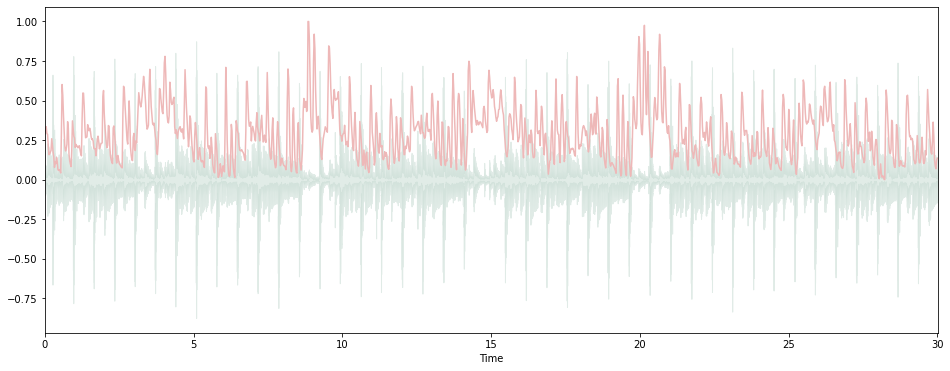

In [80]:
# Spectral Centroid waveplot에 따른 시각화
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.5, color = '#C5DAD1');#중간
plt.plot(t, normalize(spectral_centroids), color='#EEB8B8');

**Spectral Rolloff**

- 신호 모양을 측정함
- 총 spectral engergy 중 낮은 주파수 (85% 이하)에 얼마나 집중되어 있는가

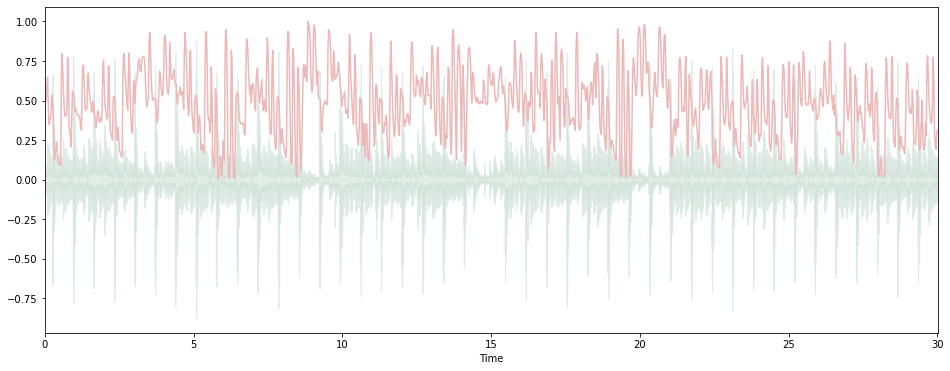

In [79]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.5, color = '#C5DAD1');
plt.plot(t, normalize(spectral_rolloff), color='#EEB8B8');

**Mel-Frequency Cepstral Coefficients**

- 음성인식에 가장 널리 사용되는 알고리즘
- 소리의 특징을 추출하는 기법
- 일정 구간으로 나누어 구간에 대한 스펙트럼을 분석하여 특징을 추출하는 기법
  - 특징들의 작은 집합 (약 10-20)으로 spectrom envelop의 총체적 모양을 축약하여 보여줌

MFCC에 대한 자세한 설명

[('MFCC란 무엇인가' 블로그 설명 글)](https://m.blog.naver.com/mylogic/220988857132)

[카카오 블로그 글](https://tech.kakaoenterprise.com//66)

mfccs shape: (20, 1293)


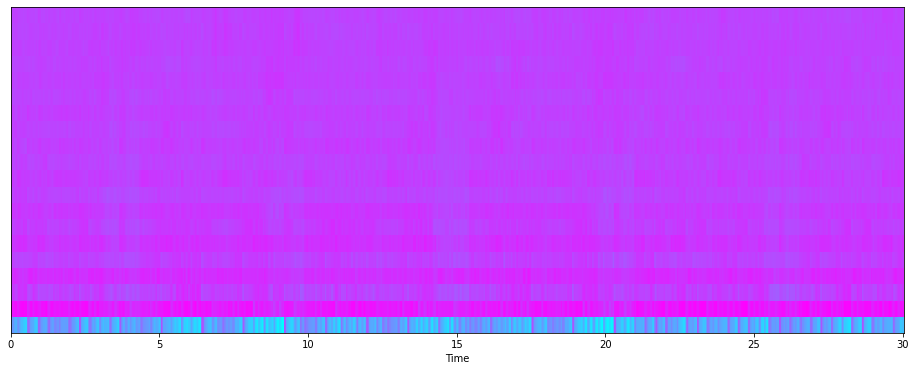

In [81]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

# MFCCs 시각화:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Feature들의 scaling이 필요하다.

Mean: 4.4254028e-10
Var: 1.0


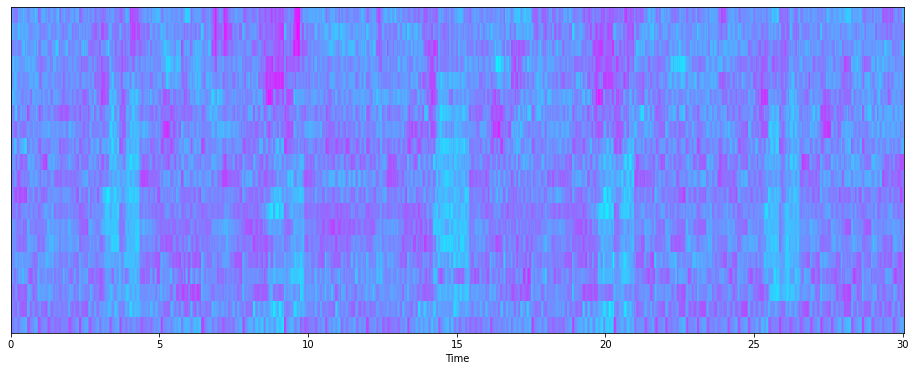

In [85]:
# Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean())
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

mean: 0.47
var: 0.03


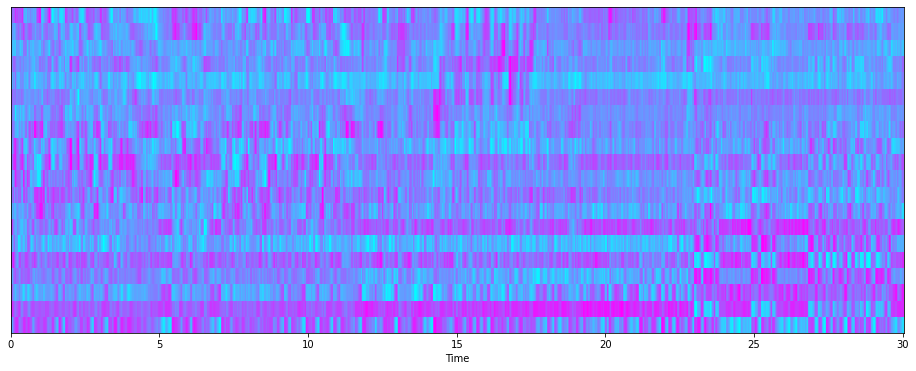

In [86]:
# 한 번에 수행하는 방법 (참고)
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs,sr=sr, x_axis='time', cmap='cool')
plt.show()

**Chroma Frequencies**

- 크로마벡터는(chroma vector): 
  - 서양음악의 12 음계로 화성적(harmonic) 특징을 나타낸 것
  - 특정 시간에 존재하는 각 반음(semitone) 들의 에너지 정보를 12차원의 벡터값으로 표현한 것
  - 12개의 반음에 대한 스펙트럼 에너지는 모든 옥타브의 같은 음들의 에너지의 합으로 나타내어 계이름에 대한 특성만 갖게 된다
  
        모든 spectrom을 12개의 bin으로 표현
        12 음계 : {C, C♯, D, D♯, E , F, F♯, G, G♯, A, A♯, B}

    [chroma란 블로그 설명 글](https://rabo0313.tistory.com/m/entry/%EC%9D%8C%EC%84%B1%EA%B8%B0%EC%B4%88-chroma)

  - chroma는  인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반한다.

Chromogram shape: (12, 1324)


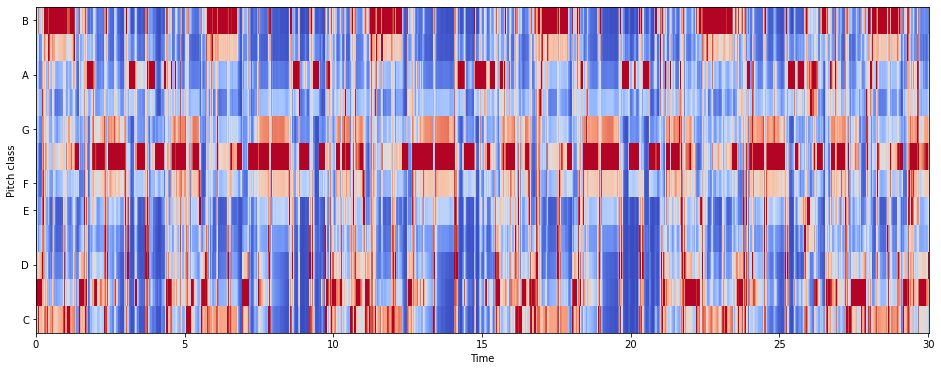

In [95]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 500

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

## EDA

In [97]:
ls

features_30_sec.csv  features_3_sec.csv  genres_original/  images_original/


In [98]:
df = pd.read_csv('features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


**Correlation Heatmap for feature means**

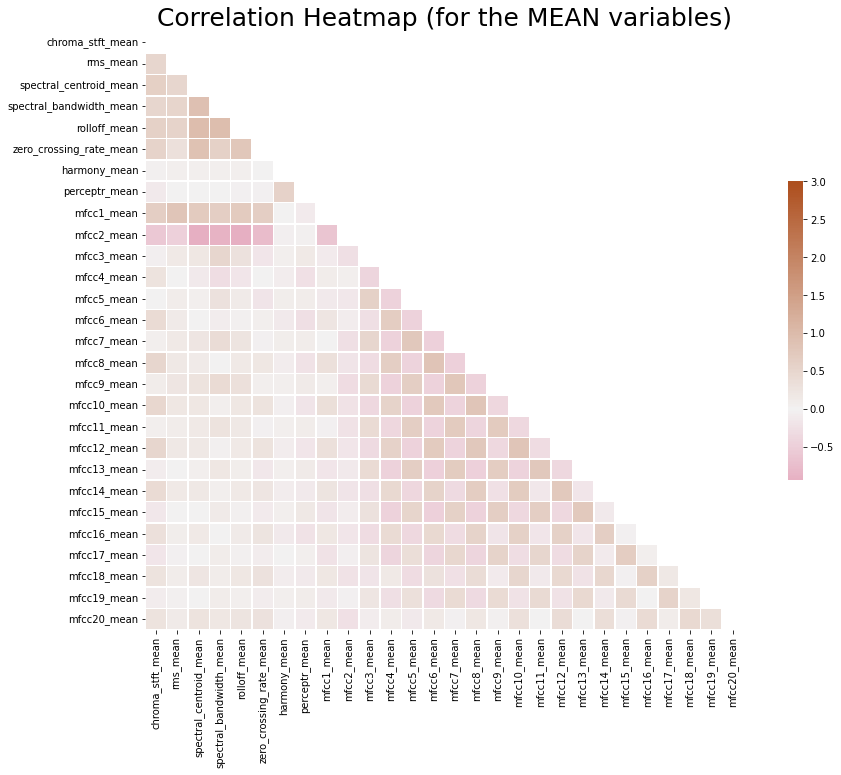

In [102]:
# Correlation Matrix 만들기
corr_mean = [col for col in df.columns if 'mean' in col]  # 'mean'이 들어있는 데이터프레임의 column을 순환하며
corr = df[corr_mean].corr()                               # mean이 들어간 column에 대하여 correlation 구함

# upper triangle을 위한 mask 형성
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# matplotlib figure 생성
f, ax = plt.subplots(figsize=(16,11));

# cmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Heatmap 그리기
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig("Corr Heatmap.jpg")                        # heatmap 저장

**Box Plot for Genres Distributions**

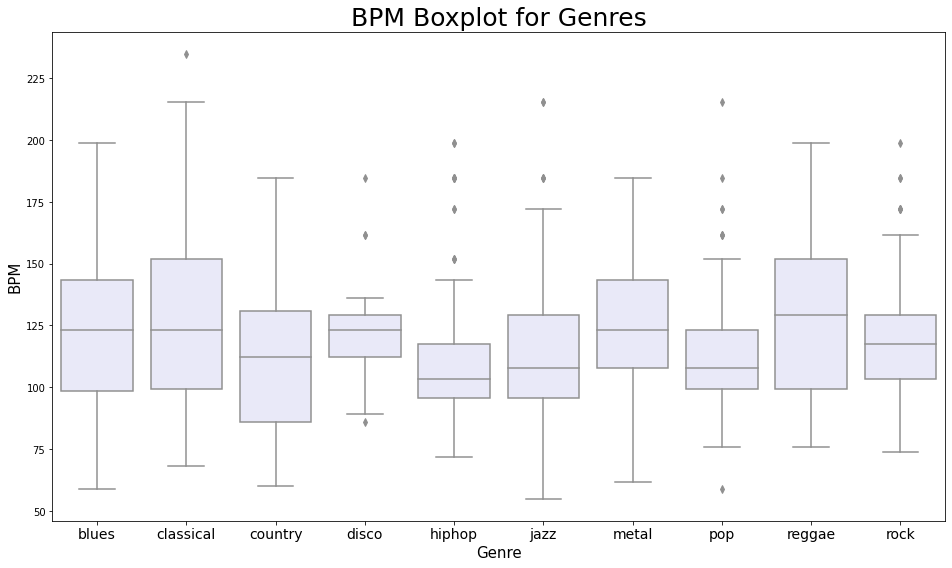

In [112]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, color='#E6E6FA');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
#plt.savefig("BPM Boxplot.jpg")

### **Principal Component Analysis (PCA: 주성분분석) - to visualize possible groups of genres: 차원축소**

- 고차원의 데이터를 저차원의 데이터로 환원

  [PCA 참고](https://ssungkang.tistory.com/entry/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5-PCA-1-Principle-Component-Analysis-%EB%9E%80)

1. normalization
2. PCA
3. scatter plot

In [114]:
df.head(3)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-0.000045,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,0.000140,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,0.000002,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues


**1) Normalization**

In [118]:
from sklearn import preprocessing

data = df.iloc[0:, 1:]                    # 첫째 행부터, 두번째 열부터  #filename 필요 없어서
y = data['label']                         # 타겟은 label
X = data.loc[:, data.columns != 'label']  # columns이 타겟인 label이 아닌 것 loc

# Normalize X
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns= cols)

In [120]:
X.head(3)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.113487,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,0.242545,0.025209,0.632779,0.094883,0.553280,0.120083,0.378307,0.738100,0.085135,0.632371,0.051568,0.482433,0.069266,0.614443,0.134574,0.462466,0.130984,0.639217,0.139176,0.351102,0.103138,0.544576,0.128074,0.381428,0.192710,0.586480,0.131694,0.433846,0.070939,0.633516,0.117862,0.587829,0.087993,0.596097,0.054619,0.413989,0.096032,0.564186,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255
1,0.113487,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,0.135778,0.048944,0.637275,0.058988,0.538949,0.064545,0.072368,0.580010,0.270406,0.644806,0.118782,0.674332,0.185998,0.549183,0.265181,0.594300,0.237271,0.678448,0.276241,0.445051,0.458711,0.653163,0.330990,0.424254,0.479508,0.610012,0.254011,0.494774,0.147203,0.545250,0.280378,0.623332,0.175153,0.546444,0.122308,0.385580,0.102385,0.570198,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947
2,0.113487,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,0.215844,0.033575,0.633932,0.190314,0.551173,0.157167,0.592014,0.776555,0.112027,0.729382,0.105689,0.414705,0.130259,0.507010,0.126493,0.354124,0.119178,0.736259,0.109374,0.351832,0.208114,0.494483,0.231821,0.391088,0.135435,0.554444,0.145195,0.328144,0.063925,0.555934,0.165714,0.458799,0.158494,0.374297,0.090245,0.277967,0.064359,0.622467,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405


normalization된 것을 확인할 수 있다.

**PCA(2차원)**

In [121]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)                                                # 정규화된 X를 pca로 fit_transform
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)                                           # pca한 것과 타겟을 병합하여 finalDf 형성
finalDf

,principal component 1,principal component 2,label
0,-0.394827,-0.115015,blues
1,0.050684,-0.271071,blues
2,-0.479969,-0.223169,blues
3,0.015376,-0.440066,blues
4,-0.162281,-0.508224,blues
...,...,...,...
995,-0.754686,-0.037197,rock
996,-0.810911,-0.028770,rock
997,-0.845392,-0.004622,rock
998,-0.235744,-0.372051,rock


In [122]:
pca.explained_variance_ratio_   # 더해서 두 pca 요소는 44.93 variance를 설명하고 있다.

array([0.2439355 , 0.21781804])

PCA의 첫번째 요소가 0.243을 차지하고, 두 번째 요소가 0.217을 차지하고 있다.

[PCA를 잘 설명한 블로그](https://ariz1623.tistory.com/216)

- sklearn의 PCA에서 고유값 분해가 아닌 특이값 분해를 사용해 계산함
  [SVD 특이값 분해 설명](https://darkpgmr.tistory.com/106)
  - 고유값 분해 : 공분산 행렬을 메모리에 갖고 있어야 함
  - 특이값 분해 : 공분산 행렬을 메모리에 저장할 필요가 없어 효율적

  - 고유값 분해를 통한 PCA 구하기 예제
  ```
X_cen = X - X.mean(axis=0)            # 평균을 0으로
X_cov = np.dot(X_cen.T, X_cen) / 59   # shape의 행 부분 60 이었음 가정
print(X_cov)
​
# np.cov()를 이용해 구할 수도 있다.
# print(np.cov(X_cen.T))
```


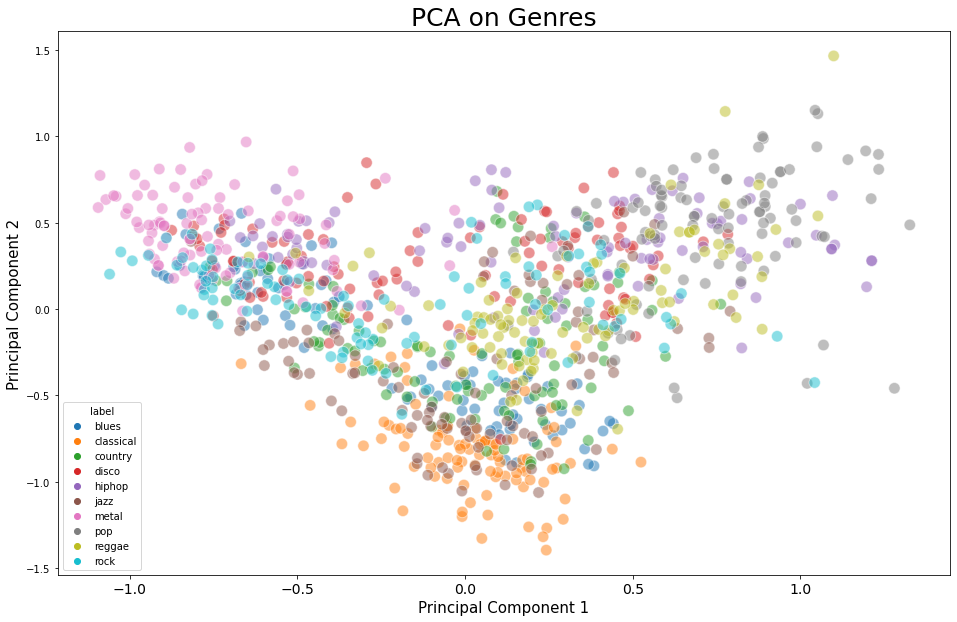

In [139]:
plt.figure(figsize = (16, 10))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.5, s = 130);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
#plt.savefig("PCA Scattert.jpg")

## **Modeling**

```features_3_sec.csv``` 파일을 이용하여 분류 모델을 형성할 것이다.



In [140]:
ls

'BPM Boxplot.jpg'    features_30_sec.csv   genres_original/  'PCA Scattert.jpg'
'Corr Heatmap.jpg'   features_3_sec.csv    images_original/


In [141]:
df_2 = pd.read_csv('features_3_sec.csv')
df_2.head(2)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues


In [142]:
data = df_2.iloc[0:,1:] # 첫행부터 filename을 제외한 두번째 열부터
data.head(2)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues


### modeling library import

In [143]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

### prepare modeling

**Normalize make new DataFrame**

In [146]:
y= data['label']
X = data.loc[:, data.columns != 'label']  # 행은 전체, columns이 label이 아닌 것 추출

# normalize X : 같은 scale을 갖도록 정규화
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new dataframe with new scaled data
X = pd.DataFrame(np_scaled, columns=cols)
X.head(3)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,0.204458,0.008479,0.627798,0.065750,0.558889,0.094009,0.398969,0.705797,0.053666,0.520907,0.049058,0.436564,0.087325,0.612386,0.077451,0.442464,0.092440,0.615847,0.079919,0.401687,0.049143,0.548711,0.143782,0.346570,0.182065,0.471486,0.188510,0.349726,0.089786,0.453269,0.074706,0.376489,0.046738,0.547239,0.050357,0.399156,0.066637,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.0,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,0.220384,0.015719,0.627315,0.038963,0.556635,0.082431,0.375552,0.696756,0.044735,0.510794,0.040432,0.451290,0.055461,0.682923,0.060499,0.385907,0.083584,0.630069,0.082378,0.402853,0.135101,0.563791,0.094805,0.376837,0.145341,0.554920,0.102538,0.326362,0.071884,0.426042,0.066947,0.330153,0.040780,0.546890,0.050933,0.380825,0.108298,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.0,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,0.173133,0.006448,0.628102,0.098196,0.567421,0.073998,0.375552,0.687860,0.083848,0.482928,0.048348,0.483199,0.045925,0.683410,0.061136,0.498369,0.076570,0.666625,0.069380,0.436689,0.122999,0.527851,0.089802,0.366354,0.271352,0.472968,0.059395,0.369542,0.062476,0.475571,0.059796,0.376549,0.058360,0.515473,0.030699,0.481771,0.078810,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062


**Train Test set split**

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [148]:
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

X_train shape:  (6993, 58)
X_test shape :  (2997, 58)
y_train shape:  (6993,)
y_test shape :  (2997,)


**모델의 accuracy를 정하기 위한 함수를 생성**

In [152]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5))

**10 가지의 모델을 시도**

In [153]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.51952
Accuracy Stochastic Gradient Descent : 0.65532
Accuracy KNN : 0.80581
Accuracy Decission trees : 0.64097
Accuracy Random Forest : 0.81415
Accuracy Support Vector Machine : 0.75409
Accuracy Logistic Regression : 0.6977
Accuracy Neural Nets : 0.67167
Accuracy Cross Gradient Booster : 0.87988
Accuracy Cross Gradient Booster (Random Forest) : 0.58859


간단히 검사한 결과 가장 성능이 좋게 나타난 모델은 0.87의 결과를 가진 XGB classifier 모델이다.

### **Final Model**

In [155]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, preds), 5))

Accuracy:  0.87988


### **분류모델 성능 평가**

confusion matrix 

지도학습으로 학습된 알고리즘 성능을 시각화해주는 행렬

- 응답 유형별로 정확한 예측과 잘못된 예측의 수를 한번에 보여주는 행렬이다.

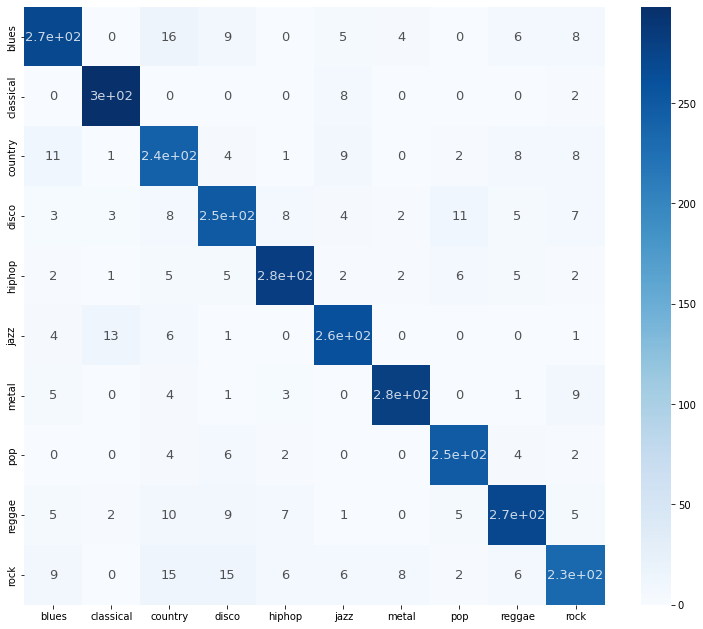

In [174]:
# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds)  # normalize = 'true'
plt.figure(figsize = (13,11))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, annot_kws={'size':13, 'alpha':0.8}, # annot_kws ={'size:12} 글자 크기 설정 가능
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
            yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
#plt.savefig("conf matrix")

가장 못 맞춘 케이스는 blues를 country음악으로 맞춘 케이스며, 그 아래로는 rock을 country와 disco로 예측한 케이스이다.

가로방향이 prediction(예측), 세로방향이 actual values(정답)이다. [(참조)](https://leedakyeong.tistory.com/entry/%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix%EB%9E%80-%EC%A0%95%ED%99%95%EB%8F%84Accuracy-%EC%A0%95%EB%B0%80%EB%8F%84Precision-%EC%9E%AC%ED%98%84%EB%8F%84Recall-F1-Score)

- Data가 불균형 할 때는 F1 score를 사용한다.


- Recall, 정밀도 계산:
  - blues라 했을 때 blues를 맞췄으면 TP, 나머지는 FP로 분류한다.



불균형하진 않지만 precision, recall을 계산해보겠다.

In [172]:
from sklearn.metrics import precision_score , recall_score

In [173]:
precision = precision_score(y_test, preds,average= "macro")
recall = recall_score(y_test, preds,average= "macro")
print('정밀도: {0:.4f}, 재현율: {1:.4f}'.format(precision, recall))

정밀도: 0.8798, 재현율: 0.8804


**feature importance**

In [ ]:
#!pip install eli5

In [171]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0902 ± 0.0090,perceptr_var
0.0493 ± 0.0067,perceptr_mean
0.0486 ± 0.0058,harmony_mean
0.0388 ± 0.0051,mfcc4_mean
0.0334 ± 0.0036,chroma_stft_mean
0.0266 ± 0.0038,harmony_var
0.0263 ± 0.0048,rms_var
0.0226 ± 0.0048,mfcc9_mean
0.0204 ± 0.0030,tempo
0.0187 ± 0.0037,mfcc11_mean


## Recommend System (추천 시스템)